<a href="https://colab.research.google.com/github/HanSong19/PALS0039-Introduction-to-Deep-Learning-for-Speech-and-Language-Processing-/blob/main/PALS0039_Ex_4_2_answers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![PALS0039 Logo](https://www.phon.ucl.ac.uk/courses/pals0039/images/pals0039logo.png)](https://www.phon.ucl.ac.uk/courses/pals0039/)

#Exercise 4.2 Age Prediction from speech

In this exercise we implement a DNN for predicting age of the speaker from speech.

The data comes from the [Accents of the British Isles](http://www.thespeechark.com/abi-2-page.html) corpus. Each speaker read the same short passage, and the audio was processed using the [OpenSMILE](https://www.audeering.com/opensmile/) toolkit into fixed-length vectors of 6373 features. We normalise the features across all speakers using z-scores. We add GENDER as an additional input feature. We convert the speaker AGE into a value between 0-1 and build a network with a linear output to predict age. We plot the predictions as a scatter plot, and calculate correlation and mean absolute error.

---
Set up the environment and load the pre-prepared data from the course website. Run the code.

In [ ]:
# import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

#scaling is very important for Deep learning. Getting the value near 0 is important and scaling is doing this

# import keras libraries
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# load a CSV file and divide into feats and labels
def load_csv(filename, outcolname="AGE", featcolstart=4):
  # read CSV file
  df = pd.read_csv(filename, sep=',')
  # convert GENDER column to codes
  gender = pd.Categorical(df['GENDER'])
  # append gender code to audio features
  inputs = np.append(np.array(df.iloc[:, featcolstart:]), np.reshape(gender.codes, (len(df),1)), axis=1)
  # convert age to numpy array
  outputs = df[outcolname].to_numpy()
  # randomise order
  p = np.random.permutation(inputs.shape[0])
  return inputs[p], outputs[p]

# download train and test data
Xtrain, ytrain = load_csv("https://www.phon.ucl.ac.uk/courses/pals0039/data/exercise_04/age-train.csv.bz2");
Xtest, ytest = load_csv("https://www.phon.ucl.ac.uk/courses/pals0039/data/exercise_04/age-test.csv.bz2");

# Show counts for the datasets
print("Number of training samples (rows):", Xtrain.shape[0], len(ytrain), sep="\t")
print("Number of test samples (rows)    :", Xtest.shape[0], len(ytest), sep="\t")
print("Number of features (columns)     :", Xtrain.shape[1], Xtest.shape[1], sep="\t")


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Number of training samples (rows):	210	210
Number of test samples (rows)    :	52	52
Number of features (columns)     :	6374	6374


---
Normalise the features using [`sklearn`'s preprocessing tools](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing). Run the code.

In [ ]:
# Get statistics of all features
scaler = StandardScaler().fit(Xtrain)

# Normalise the training and test features
Xtrain_norm = scaler.transform(Xtrain)
Xtest_norm = scaler.transform(Xtest)

# Convert ages to a small number
# Maximum ages in the data are in the 80s
# So outputs should lie well inside the range [0.0, 1.0]
# output is not normalized because it is difficult ro read what the normalized value is in terms of the real values. 
ytrain_norm = ytrain / 100.0
ytest_norm = ytest / 100.0

---
(a) Build a model. Run the code and add comments. Why do we use the `tanh` activation function for the hidden layers? What is the [`Dropout` layer](https://keras.io/api/layers/regularization_layers/dropout/)?

In [ ]:
def build_model(input_width, output_width=1):
  model = Sequential()
  model.add(Dense(64, activation='tanh', input_shape=(input_width,)))
  #dropoupt is the new thing 
  #dropout is one option to do regularisation that preents overfitting. Dropout ignore some units during training. 
  #during the first trining, i drop 50% of training (but not prediction) and the rest 50% of them are trained. IN the next iterating of learning
  #another 50% the training nodes are dropped (it is random so it is likely to be different nodes)
  model.add(Dropout(0.5))
  model.add(Dense(32, activation='tanh'))
  #activation = 'tanh' because drop puts excluded one to '0' but in ,activation sigmoid (that looks in between 0-1), '0' means something so here tanh puts in the middle
  # tanh is between -1 to 1 and 0 can be in the middle
  model.add(Dense(output_width, activation='linear'))
  model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
  #mae= mean absolute error but I can still use mse as well
  return model

#(a)
model = build_model(input_width=Xtrain.shape[1])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 64)                408000    
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 410,113
Trainable params: 410,113
Non-trainable params: 0
_________________________________________________________________


---
(b) Call the `model.fit` method with the correct arguments to train the model with the following specifications: (1) Train for 100 iterations over the dataset; (2) Update the weights during training in batches of 32 samples; (3) Request Keras to randomly select 10% of the training set as the **validation set**.

In [ ]:
training_info = model.fit(Xtrain_norm, ytrain_norm, epochs=100, batch_size=32, validation_split=0.1)

Epoch 1/100
6/6 [==============================] - 1s 37ms/step - loss: 2.1921 - mae: 1.0992 - val_loss: 1.0185 - val_mae: 0.8540
Epoch 2/100
6/6 [==============================] - 0s 12ms/step - loss: 0.8079 - mae: 0.7561 - val_loss: 0.6123 - val_mae: 0.5924
Epoch 3/100
6/6 [==============================] - 1s 174ms/step - loss: 0.6006 - mae: 0.6112 - val_loss: 0.6214 - val_mae: 0.5877
Epoch 4/100
6/6 [==============================] - 0s 11ms/step - loss: 0.5495 - mae: 0.6063 - val_loss: 0.6453 - val_mae: 0.6455
Epoch 5/100
6/6 [==============================] - 0s 10ms/step - loss: 0.4855 - mae: 0.5773 - val_loss: 0.5600 - val_mae: 0.6369
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 0.4519 - mae: 0.5321 - val_loss: 0.5750 - val_mae: 0.6643
Epoch 7/100
6/6 [==============================] - 0s 13ms/step - loss: 0.2985 - mae: 0.4428 - val_loss: 0.4087 - val_mae: 0.5190
Epoch 8/100
6/6 [==============================] - 0s 10ms/step - loss: 0.3378 - mae: 0.4

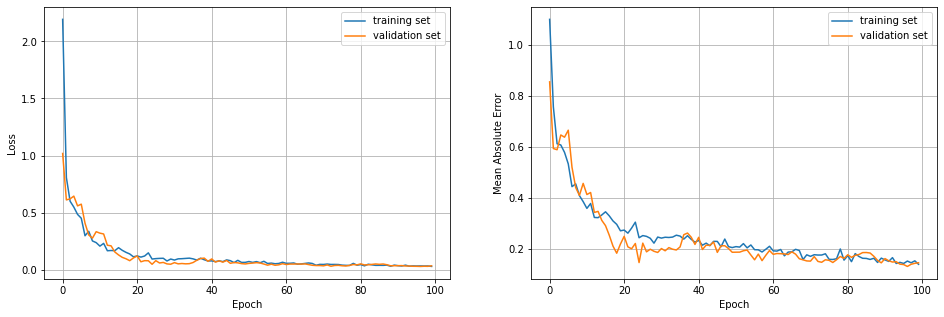

In [ ]:
def plot_training_history(training_info):
  # Plot the training process:
  fig, axs = plt.subplots(1, 2, figsize=(16, 5))
  axs[0].plot(training_info.history['loss'], label="training set")
  axs[0].plot(training_info.history['val_loss'], label="validation set")
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("Loss")
  axs[0].grid(True)
  axs[0].legend()
  try:
    axs[1].plot(training_info.history['mae'], label="training set")
    axs[1].plot(training_info.history['val_mae'], label="validation set")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Mean Absolute Error")
    axs[1].grid(True)
    axs[1].legend()
  except:
    pass
  plt.show()

plot_training_history(training_info)

(c) Does the process exhibit overfitting or underfitting? Is the performance of the classifier good? Is 100 epochs a reasonable choice? Should the number of epochs be increased or decreased? How could it be that the training error is larger than the validation error?

In [ ]:
#(c)
# - Neither underfitting nor overfitting
# - The MAE * 100.0 indicates a mean error in years of ~ 15. Compare RMSE to SD of outputs - is it better than guessing the mean for everybody?
# - Looks like number of epochs could be left as-is or increased
# - The validation error could be lower because training error is calculated with dropout.

print(np.std(ytrain))

18.055957365143563


(d) Estimate the generalisation performance of the two models on the test set (use the [model.evaluate method](https://keras.io/api/models/model_training_apis/#evaluate-method). How does the test accuracy compare to those on the validation set?

In [ ]:
#(d)
test_loss, test_mae = model.evaluate(Xtest_norm, ytest_norm, verbose=0)
print("Test loss:", test_loss)
print("Test Mean Absolute Error (years):", test_mae * 100.0)

Test loss: 0.026991846039891243
Test Mean Absolute Error (years): 12.954181432723999


---
Plot predictions vs. actual age, run the code.

2/2 [==============================] - 0s 7ms/step


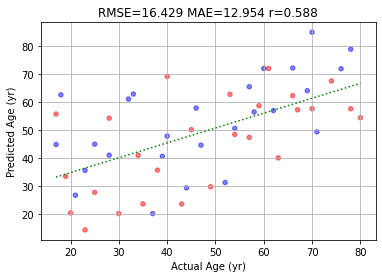

In [ ]:
# get predictions of model
ypred_norm = model.predict(Xtest_norm)

# convert back to years
ypred = ypred_norm.flatten() * 100.0

# calculate some statistics
rmse = np.sqrt(np.mean((ytest - ypred) * (ytest - ypred)))
mae = np.mean(np.abs(ytest - ypred))
corr = np.corrcoef(ytest, ypred);

# plot male and female in different colours
colours = ['red','blue']
cols = list(colours[int(i)] for i in Xtest[:,Xtest.shape[1] - 1])
# plot a scatter plot
plt.scatter(x=ytest, y=ypred, c=cols, s=20, alpha=0.5);
# calculate a line of best fit
poly = np.polyfit(ytest, ypred, 1)
x = np.array((np.min(ytest), np.max(ytest)))
y = poly[1] + poly[0] * x
plt.plot(x,y,':g')
plt.xlabel("Actual Age (yr)");
plt.ylabel("Predicted Age (yr)");
plt.grid()
plt.title("RMSE=%.3f MAE=%.3f r=%.3f" % (rmse, mae, corr[0, 1]));
plt.show()


---
(e) **Optional**: Experiment with the network to try and improve performance. Some ideas:

- Remove the feature normalisation step - is it useful?
- Change the structure of the network or training regime (advanced) Select a subset of the 6373 features depending on whether the feature has a useful correlation with speaker AGE. Remove features from the training and test sets which do not correlate with age to any useful degree.
- What is the benefit of feature selection here, does it improve the accuracy of the model?
